In [173]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import linear_model
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

from sklearn import manifold
from sklearn.metrics import euclidean_distances

In [174]:
data = pd.read_csv('dataset_formatted_fixed.csv')
filtered_data_frame = data[['width', 'length', 'height', 'capacity']].dropna()


filtered_data_frame = filtered_data_frame[filtered_data_frame['capacity'] <= 40]
filtered_data_frame = filtered_data_frame[filtered_data_frame['width']    <= 3 ] 
filtered_data_frame = filtered_data_frame[filtered_data_frame['height']   <= 3 ] 
filtered_data_frame = filtered_data_frame[filtered_data_frame['length']   <= 20]

filtered_data_matrix = filtered_data_frame.values
pca = decomposition.PCA(n_components=3)
pca.fit(filtered_data_frame.values)

def make_reduction_to_dims(n_dims):
    filtered_data_matrix = filtered_data_frame.values
    pca = decomposition.PCA(n_components=n_dims)
    pca.fit(filtered_data_frame.values)
    transform_data = pca.transform(filtered_data_matrix)
    reverse_transform = pca.inverse_transform(transform_data)
    return transform_data, reverse_transform

Отфильтруем данные и опишем функцию, которая выполняет сжатие исходных данных до данных с заданной размерностью базиса.

Воспользуемся методом главных компонент для сокращения размерности данных с минимально возможными потерями.

In [175]:
print(reverse_transform)
print(pca.score_samples(filtered_data_matrix))
print(pca.get_precision())

[[ 2.12042577  3.79906678  2.18897632  6.00217335]
 [ 1.83894507  2.9994624   1.808864    2.50125201]
 [ 2.04938293  5.09949724  2.1018086   5.00117086]
 ..., 
 [ 1.87771219  3.9995918   1.88265963  1.50095064]
 [ 1.92677371  3.99975557  1.94949682  2.00056925]
 [ 1.66553689  2.79971806  1.55709227  2.0006566 ]]
[-6.00916855 -4.47508056 -4.07392782 ..., -4.08847521 -3.75934139
 -4.64088923]
[[ 25.96462457  -0.31265378 -12.13874519  -0.23195636]
 [ -0.31265378   0.38042212  -0.62825686  -0.1001697 ]
 [-12.13874519  -0.62825686  16.20859458   0.04869647]
 [ -0.23195636  -0.1001697    0.04869647   0.05494083]]


Посмотрим предложенные методы оценки точности из пакета sklearn.
Это - логарифмическая оценка расхождения, что конечно же неплохо, но напишем свою, человеко-понятную оценку - вторую норму -
эвклидово расстояние между векторами.

In [176]:
def get_generative_params(data_matrix):
    return [(row[:3],row[3]) for row in data_matrix]

def measure_vector_precision(row1, row2):
    return sum([(row1[i] - row2[i]) ** 2 for i in range(len(row1))]) ** 0.5

def avg_vector(generative_row1, generative_row2):
    return [(generative_row1[i] + generative_row2[i])/2 for i in range(len(generative_row1))]

def point_from_data(row1, row2, div_length):
    return avg_vector(row1[0], row2[0]), measure_vector_precision(row1[0] , row2[0])/div_length

def get_point_color(point):
    w = 1 - max(0, min(1, point[1]))
    return (w,w,1,1)

def analyze(initial_data, reverse_transform):
    initial_data = get_generative_params(filtered_data_frame.values)
    reduced_data = get_generative_params(reverse_transform)
    
    data_reduction_precision_estimate = np.array([measure_vector_precision(filtered_data_frame.values[i], reverse_transform[i]) for i in range(len(initial_data))])
    print("quick precision estimate: ", data_reduction_precision_estimate[:10])
    min_divergence, max_divergence = data_reduction_precision_estimate.min(), data_reduction_precision_estimate.max()
    divergence_length = max_divergence - min_divergence

    print("min_div: {}, max_div: {}, avg: {}".format(min_divergence, max_divergence, sum(data_reduction_precision_estimate)/ len(data_reduction_precision_estimate)))

    points_to_plot = [point_from_data(initial_data[i], reduced_data[i], divergence_length) for i in range(len(initial_data))]

    fig = plt.figure(1, figsize=(16, 12))
    #plt.clf()
    ax = Axes3D(fig, rect=[0, 0, .95, 1])
    #plt.cla()

    points_bulk = [[point[0][0] for point in points_to_plot],
                  [point[0][1] for point in points_to_plot],
                  [point[0][2] for point in points_to_plot]]



    points_colors = [get_point_color(points_to_plot[i]) for i in range(len(points_to_plot))]

    ax.scatter(points_bulk[0],points_bulk[1], points_bulk[2], c=points_colors)

Описан набор функций для анализа возможностей снижения размерности данных.
Планируется в процессе анализа получить такие данные:
1. минимальное, максимальное и среднее расхождение для каждой строки данных
2. оценку точности метода снижения размерности
3. наглядное представления итога снижения размерности
График следует читать так: в осях обозначены габариты автомобиля. Каждая точка означает набор габаритов. Цвет точки - значение расхождения
данных сниженной размерности по отношению к исходным данным. Объем кузова не отображается, так как известно, что он функционально зависит от остальных данных.

quick precision estimate:  [ 1.41137143  0.99381707  0.2707114   0.17988996  0.20400226  0.5166094
  0.39971088  0.39971088  1.09546235  0.41725563]
min_div: 0.04849282571845874, max_div: 10.635444446652057, avg: 1.0392087964651708


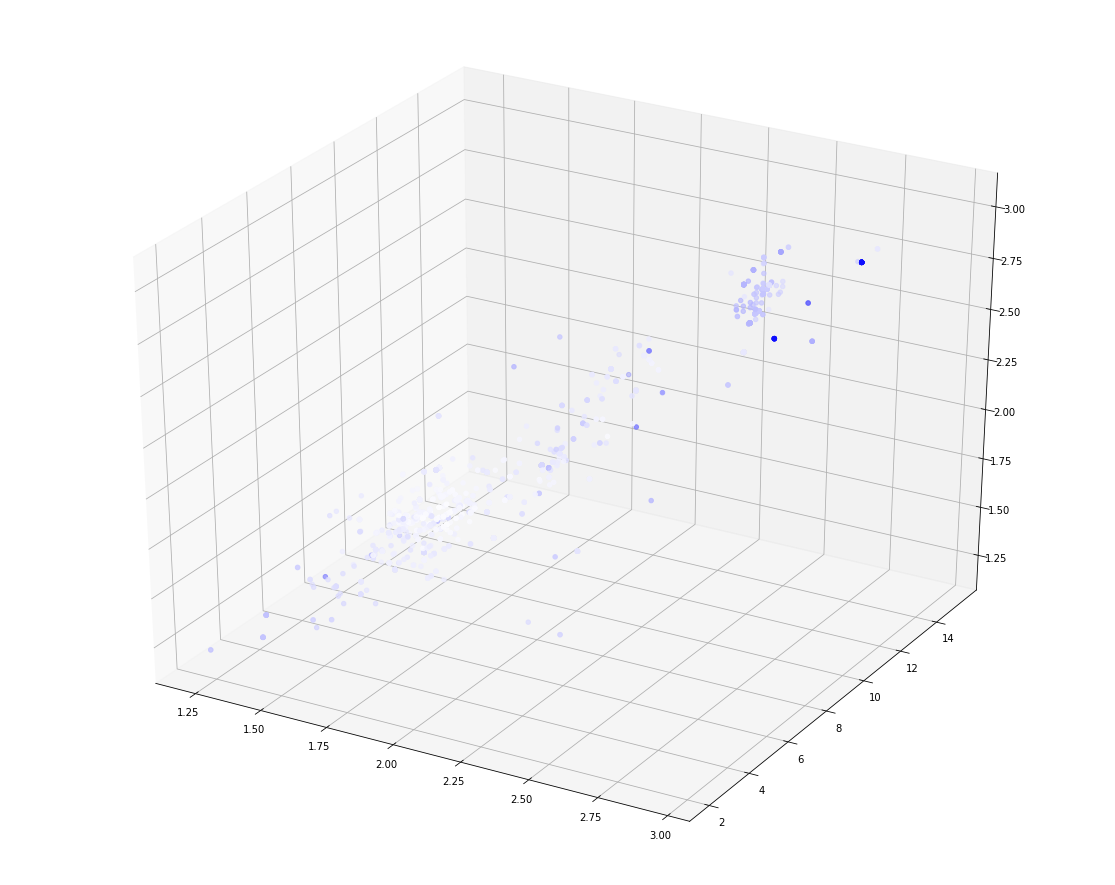

In [177]:
initial, reduced = make_reduction_to_dims(1)
analyze(initial, reduced)

Попробуем снизить размерность базиса до 1. Проанализируем полученные данные:
1. Максимальное расхождение данных - примерно 10, что достаточно много
2. В среднем, разлет исходных данных от преобразованных обратно примерно равен 1
3. По графику видим, что 2 облака точек имеют ярко выраженное различие: левое протяженное облако имеет меньшее расхождение, т.к. находится вдоль продольной оси, которая выбрана определяющим базисом сниженной размерности. правое облако имеет значительно большее расхождение, т.к. расположено на значительном расстоянии от первого, т.к. в этих точках влияние значений других компонент векторов данных сильнее.

quick precision estimate:  [ 0.41838627  0.22653473  0.18406772  0.09554279  0.2021794   0.04911154
  0.17691883  0.17691883  1.021137    0.20876989]
min_div: 0.020356025545985246, max_div: 2.863554293799793, avg: 0.313477334963445


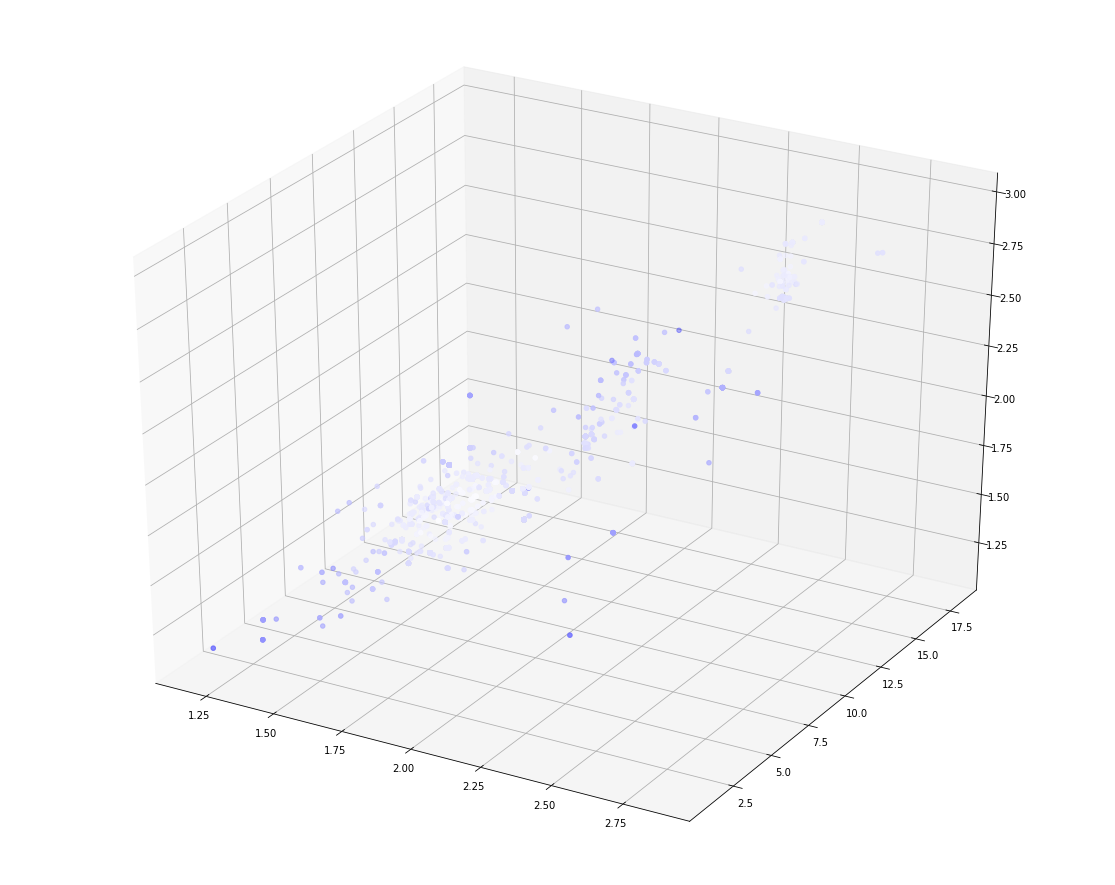

In [178]:
initial, reduced = make_reduction_to_dims(2)
analyze(initial, reduced)

Попробуем снизить размерность базиса до 2. Проанализируем полученные данные:
1. Максимальное расхождение данных - примерно 3
2. В среднем, разлет исходных данных от преобразованных обратно примерно равен 0.31
3. По графику видим, что большинство точек  имеют небольшое расхождение. Расхождение скорее видно на обособленных точках,
    в которых, вероятно, имеются проблемы с данными. То что хватает базиса 2 объясняется законами предметной области - 
    из того, что высоты и ширины автомобилей примерно равны, наиболее определяющим параметром является длина, а ширина следует из 
    высоты по соображениям устойчивости транспортного средства.

quick precision estimate:  [ 0.33746021  0.19440143  0.18180241  0.08838783  0.08549816  0.03616148
  0.05978831  0.05978831  0.52438747  0.07905785]
min_div: 3.096828100027374e-05, max_div: 1.1538686645111245, avg: 0.12690679427206797


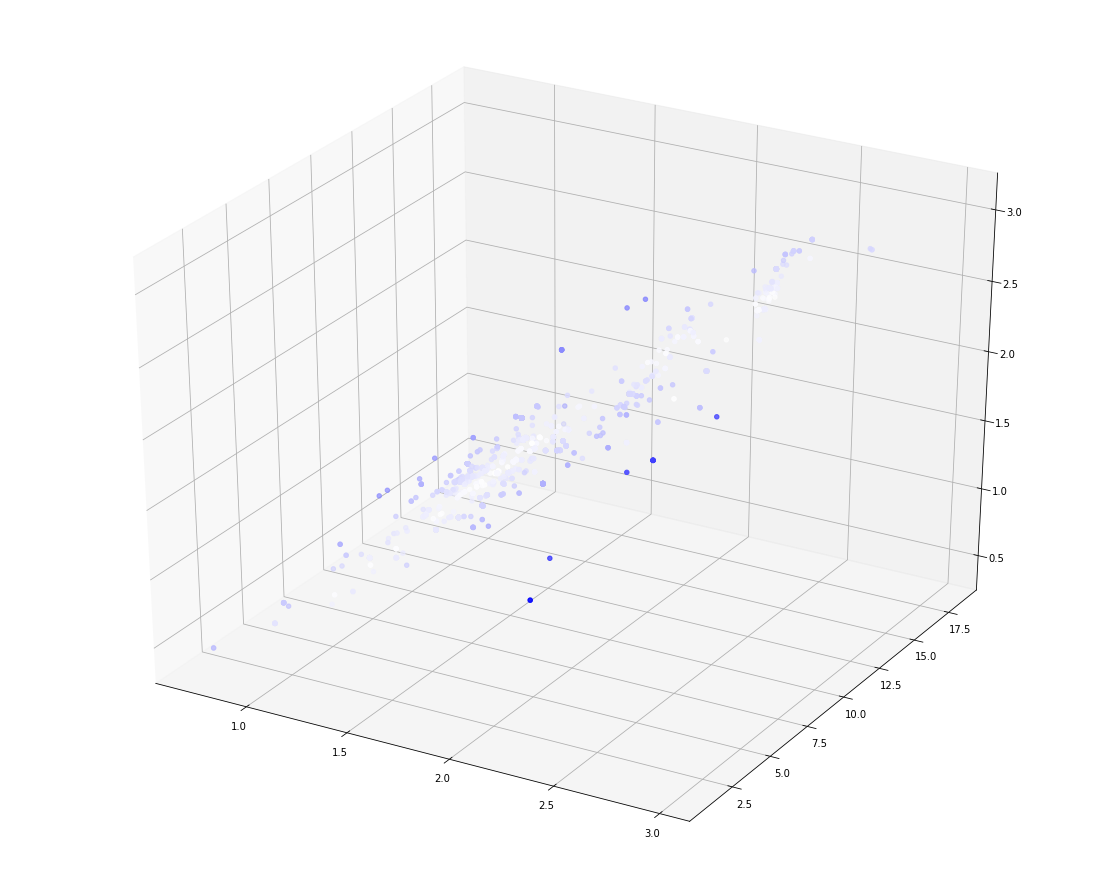

In [179]:
initial, reduced = make_reduction_to_dims(3)
analyze(initial, reduced)

Попробуем снизить размерность базиса до 3. Проанализируем полученные данные:
1. Максимальное расхождение данных - примерно 1
2. В среднем, разлет исходных данных от преобразованных обратно примерно равен 0.1
3. По графику видим, что выделить области где точки будут лучше определены выделить сложно, т.к. расхождение равномерно для всех точек.
    Поскольку объем явно следует из габаритов, базис размера 3 полностью определяет строку данных по математическому закону.
    Расхождения объясняются особенностями моделей машин - к примеру, шириной стенок контейнера и т.п.
4. Белая линия точек - интуитивно является машинами с толщиной стенок кузова равной 0, т.е. объем в точности равняется произведению габаритов.
Выполняется ожидаемое поведение: снижение размерности данных до 3 не портит данные, так как известно, что существует функциональная
зависимость, определяющая остальные данные.

([<matplotlib.axis.XTick at 0x11acd1710>,
 <a list of 3 Text xticklabel objects>)

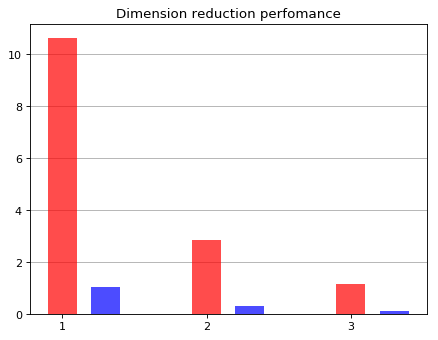

In [180]:

data_names = ['1', '2', '3']
data_values = [10.63, 2.86, 1.153868664511125]
avg_values = [1.03,0.31, 0.12]

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )

plt.title('Dimension reduction perfomance')

ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)

xs = range(len(data_names))

plt.bar([x for x in xs], data_values,
        width = 0.2, color = 'red', alpha = 0.7, label = '2016',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], avg_values,
        width = 0.2, color = 'blue', alpha = 0.7, label = '2017',
        zorder = 2)
plt.xticks(xs, data_names)


Посмотрим, как размерносить базиса для сжатия данных определяет качество данных при обратном преобразовании.
Видим, что среднее значение расхождения допустимо мало для любого размера базиса, максимальное расхождение распределено
по закону, что похож на 1/x для текущего набора данных.

In [181]:
def calc_mds(n_dims):  
    n_samples = len(filtered_data_matrix)
    matrix = np.array(filtered_data_matrix[:500])#.reshape((n_samples, 2))
    matrix -= matrix.mean()
    similarities = euclidean_distances(matrix)
    # print(similarities)
    mds = manifold.MDS(dissimilarity='precomputed', n_components=n_dims)
    pos = mds.fit(similarities).embedding_
    return pos


Рассмотрим метод многомерного шкалирования.
У него такие особенности:
1. Меняет систему координат и уменьшает размерность пространства.
2. Отношение между одинаковыми объектами сохраняется, а вот расстояние между разными может меняться при повторном запуске алгоритма.
3. Этот алгоритм не предполагает обратное преобразование данных в исходное пространство.
4. Алгоритм работает на основании матрицы расстояний между объектами, причем допускается произвольное определение функции расстояния.
    По этой причине, алгоритм допускает потенциально большее количество вариантов применения.

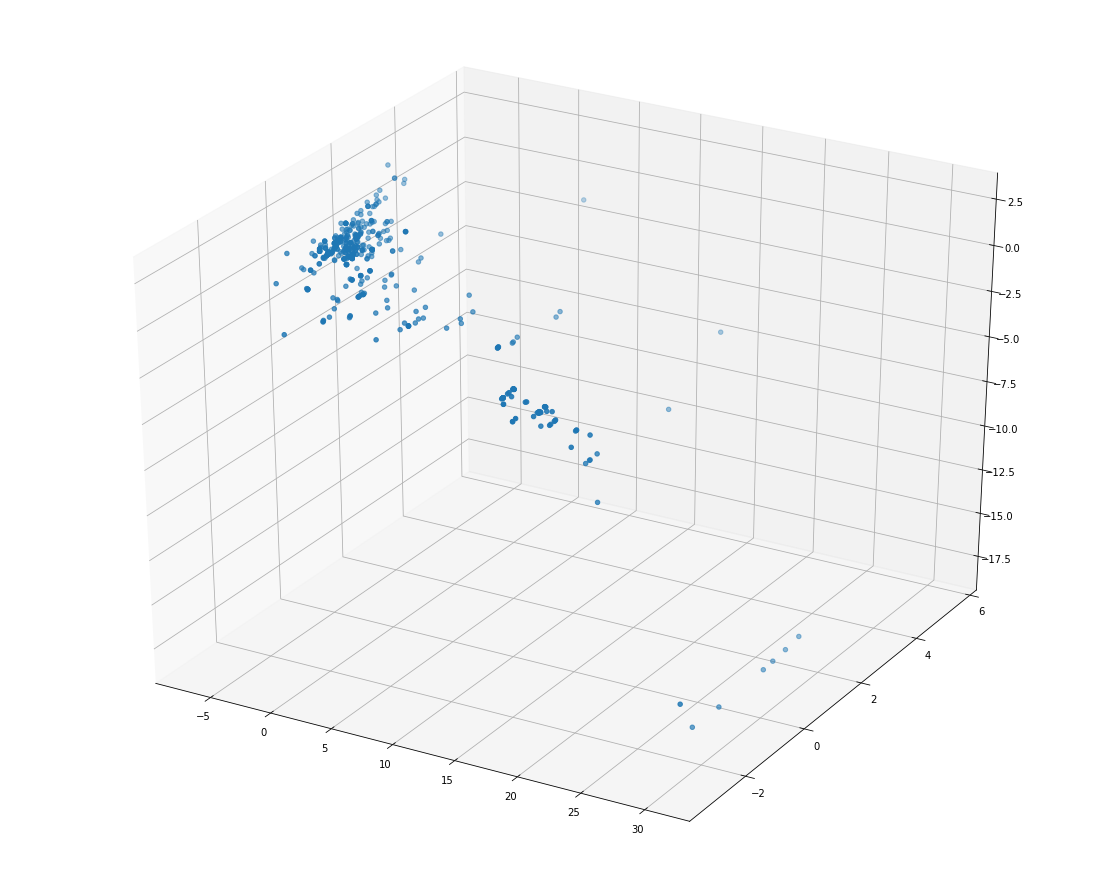

In [182]:
points = calc_mds(3)
points_bulk = [[point[0] for point in points],
              [point[1] for point in points],
              [point[2] for point in points]]
fig = plt.figure(1, figsize=(16, 12))
ax = Axes3D(fig, rect=[0, 0, .95, 1])
ax.scatter(points_bulk[0], points_bulk[1], points_bulk[2])

Применим метод многомерного шкалирования с размерностью пространств 3.
Назвать оси сложно, хотя интуитивно это должны быть оси габаритов транспортного средства в другом базисе - 
повернутые и смещенные.

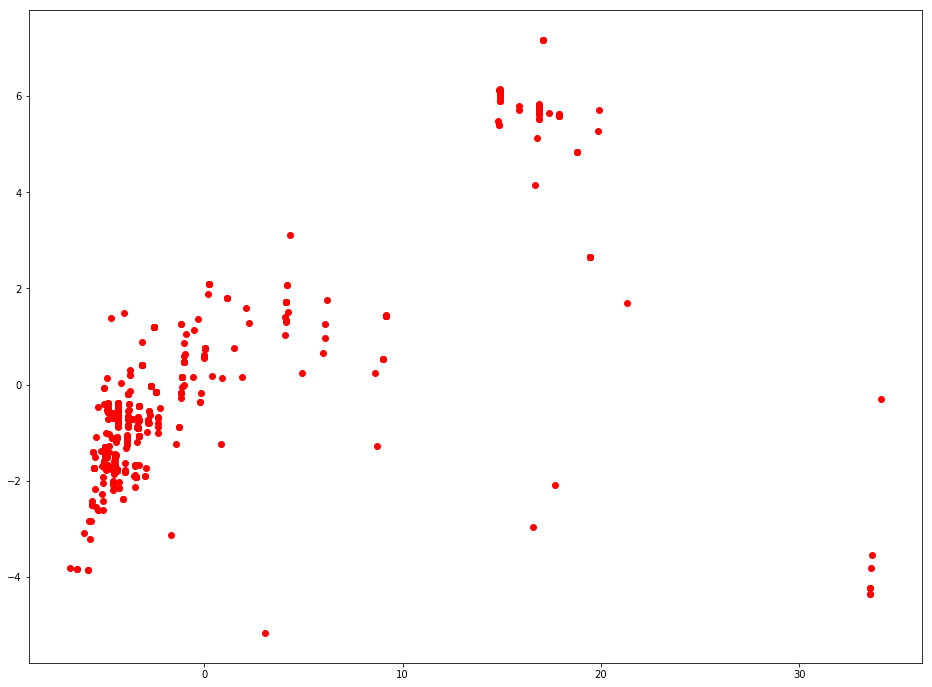

In [206]:
points = calc_mds(2)
points_bulk = [[point[0] for point in points],
              [point[1] for point in points]]
fig = plt.figure(1, figsize=(16, 12))
plt.plot(points_bulk[0], points_bulk[1], 'ro')

Применим метод многомерного шкалирования со сжатием пространства до 2.
Оси назвать стало еще сложнее, хотя исходя из предметной области это скорее всего повернутые и смещенные оси длины контейнера ТС 
и высота либо ширина(нет разницы), так как они связаны функционально. Можно заметить, что точки на графике от запуска к запуску вращаются(но не относительно друг друга), т.к. опорная система координат каждую прогонку метода выбирается случайно.

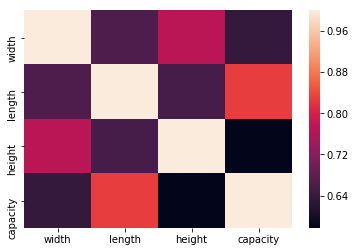

In [190]:
data_norm = (filtered_data_frame - filtered_data_frame.mean()) / (filtered_data_frame.max() - filtered_data_frame.min())
corr = data_norm.corr()

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)



Приступим к факторному анализу.
Нормализуем данные и построим график корреляции величин.
Видим, что в исходной выборке объем сильнее всего зависит от длины кузова, т.к. остальные параметры близки между собой по
численному значению.

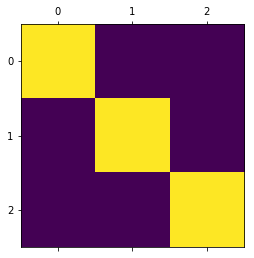

In [192]:
pca = decomposition.PCA(n_components=3)
pca.fit(filtered_data_frame.values)
transform_data = pca.transform(filtered_data_matrix)
new_data = pd.DataFrame(transform_data)
plt.matshow(new_data.corr())

Построим матрицу корреляций для точек в сокращенном пространстве.
Эта матрица показывает, что корреляции между величинами отсутствуют. То, что корреляции нет - говорит как минимум о том, что эта размерность меньше либо равна оптимальной для сжатия. Поскольку 4-3 = 1, можно предположить, что это оптимальное сжатие исходного пространства с минимальными потерями.

In [203]:
#построим матрицу нагрузок. вектор на корень собственных значений
def get_eigenvalues():
    return pca.explained_variance_

def get_eigenvectors():
    return pca.components_

def get_loadings():
    return get_eigenvectors() * np.sqrt(get_eigenvalues().reshape((3,1)))

#точки нагрузки
print(get_eigenvectors().T)
print(get_eigenvalues())
A = get_loadings()
#матрица нагрузки
print(A)

[[ 0.02636549 -0.0416959  -0.55786271]
 [ 0.33189637 -0.93901085  0.08997655]
 [ 0.02980539 -0.07016451 -0.82498073]
 [ 0.94247615  0.3340614   0.01001013]]
[ 67.94953359   2.81507088   0.1239442 ]
[[  2.17334715e-01   2.73587179e+00   2.45690342e-01   7.76897297e+00]
 [ -6.99581056e-02  -1.57548864e+00  -1.17723234e-01   5.60493997e-01]
 [ -1.96399524e-01   3.16768832e-02  -2.90440318e-01   3.52413693e-03]]


In [204]:
#выведем матрицу вклада каждого измерения в дисперсию
print(pca.explained_variance_ratio_)


[ 0.95814479  0.03969483  0.00174772]


Видимо, первая компонента - длина, так как она лучше всего определяет объем. Кроме того, остальные компоненты - высота и ширина сами
зависят функционально друг от друга и меняются незначительно для различных ТС.

Вывод.
    Методы сжатия размерности помогают выделить ключевые поля данных, которые могут с достаточной точностью определить остальные поля. Это используется в различных задачах для безвредного отбрасывания лишних данных. Метод главных компонент - детерминированный метод получения преобразования в новую систему координат с меньшим количеством осей, сохраняющую отношения между данными. Метод оперирует матрицей корреляционного отношения полей данных чтобы построить новое пространство.
    Метод многомерного шкалирования - метод преобразования системы координат на основании матрицы произвольного расстояния между строками данных. В теории, он является более гибким, так как допускает вычисления на базе любой функции расстояния между строками данных. Обычно, когда используют этот метод, не ставят цель преобразовать данные в исходную систему координат, но продолжают анализ данных с скоращенной размерностью, поскольку метод сохраняет исходное отношение в наборе данных.
    Факторный анализ помогает оценить влияние главных компонент на остальные поля строки данных. Таким способом можно искать закономерности в данных. В процессе можно найти опорные точки - строки данных в значительной мере определяющие базис нового пространства.